In [1]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
"List of Cancer Types in PCAWG Dataset"
cancer_type_list = ['Biliary-AdenoCA',
 'Bladder-TCC',
 'Bone-Benign',
 'Bone-Epith',
 'Bone-Osteosarc',
 'Breast-AdenoCA',
 'Breast-DCIS',
 'Breast-LobularCA',
 'CNS-GBM',
 'CNS-Medullo',
 'CNS-Oligo',
 'CNS-PiloAstro',
 'Cervix-AdenoCA',
 'Cervix-SCC',
 'ColoRect-AdenoCA',
 'Eso-AdenoCA',
 'Head-SCC',
 'Kidney-ChRCC',
 'Kidney-RCC',
 'Liver-HCC',
 'Lung-AdenoCA',
 'Lung-SCC',
 'Lymph-BNHL',
 'Lymph-CLL',
 'Myeloid-AML',
 'Myeloid-MDS',
 'Myeloid-MPN',
 'Ovary-AdenoCA',
 'Panc-AdenoCA',
 'Panc-Endocrine',
 'Prost-AdenoCA',
 'Skin-Melanoma',
 'SoftTissue-Leiomyo',
 'SoftTissue-Liposarc',
 'Stomach-AdenoCA',
 'Thy-AdenoCA',
 'Uterus-AdenoCA']


In [3]:
def abs_path(target_name, directory_level): 
    """
Returns absolute file path of target name in working directory.

Arguments:
    target_name (str): Name of file or folder to find.
    directory_level (str): Level of os search, either File or Folder.   
    """
    #Find the relative working directory of the script
    wk_dir = os.path.dirname(os.path.realpath('__file__'))
    
    if directory_level == "File":
        #Absolute file path
        for root, dirs, files in os.walk(wk_dir):
            for name in files:
                if target_name == name:
                    target_path = (os.path.abspath(os.path.join(root, name))) 
             
    #Absolute file path
    if directory_level == "Directory":
        for root, dirs, files in os.walk(wk_dir):
            for name in dirs:
                if target_name == name:
                    target_path = (os.path.abspath(os.path.join(root, name))) 
    
    return target_path

In [4]:
def ref_data(input_name, num=False, prop=False):
    """
Reads in reference datasets from PCAWG studies.

Arguments:
    input_name (str): Name of csv file 
    num (bool): Set true to return dataframe of PCAWG SigProfiler Signatures in Samples 
    prop (bool): Set true to return dataframe of SigProfiler Signature Contributions
    
Note: Must set only one of num or prop arguments to True. 
    """
    if prop == num:
        raise ValueError("Please set only one argument between the arguments num and prop to True.")
        
    if num is True:
        
        num_file_path = abs_path(input_name, "File")
        num_data = pd.read_csv(num_file_path)
        num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
        num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)
        
        return num_data

    if prop is True:
            
        prop_file_path = abs_path(input_name, input_type )
        prop_data = pd.read_csv(prop_file_path)
        
        return prop_data
    

In [5]:
"""
SBS input reference files
"""
sbs_num_file_path = abs_path("PCAWG_sigProfiler_SBS_signatures_in_samples.csv","File")
sbs_num_data = pd.read_csv(sbs_num_file_path)
sbs_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
sbs_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

sbs_prop_file_path = abs_path("sigProfiler_SBS_signatures.csv","File")
sbs_prop_data = pd.read_csv(sbs_prop_file_path)
  

"""
DBS input reference files
"""
dbs_num_file_path = abs_path("PCAWG_sigProfiler_DBS_signatures_in_samples.csv","File")
dbs_num_data = pd.read_csv(dbs_num_file_path)
dbs_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
dbs_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

dbs_prop_file_path = abs_path("sigProfiler_DBS_signatures.csv","File")
dbs_prop_data = pd.read_csv(dbs_prop_file_path)


"""
Insertion/Deletion input reference files
"""
id_num_file_path = abs_path("PCAWG_SigProfiler_ID_signatures_in_samples.csv","File")
id_num_data = pd.read_csv(id_num_file_path)
id_num_data.sort_values(by='Cancer Types', axis=0, inplace=True)
id_num_data.set_index(keys=['Cancer Types'], drop=False,inplace=True)

id_prop_file_path = abs_path("sigProfiler_ID_signatures.csv","File")
id_prop_data = pd.read_csv(id_prop_file_path)

"""
Expected Frequency Absolute Folder Paths for SBS, DBS and ID
"""
sbs_freq_folder_path = abs_path("SBS_Expected_Frequency", "Directory")
dbs_freq_folder_path = abs_path("DBS_Expected_Frequency", "Directory")
id_freq_folder_path = abs_path("ID_Expected_Frequency", "Directory")

In [6]:
def sig_proportion(cancer_type, num_data, std_outlier):
    """
Find the proportions of different combinations of signatures among all samples
Output proportion of samples with each combination of signatures. 

Arguments:
    cancer_type (str): Cancer type 
    num_data (dataframe): Signature data
    std_outlier (float): Parameter to exclude outliers by degrees of standard deviation 
    """
    #Setup dataframe with signature data
    n_mutation_df = num_data.loc[cancer_type,"Sample Names":]
    n_mutation_df.set_index("Sample Names", inplace=True)
    del n_mutation_df['Accuracy']
    
    cols = n_mutation_df.columns
    
    #Find contributing signature combinations for each sequence
    sig_combos = list(n_mutation_df.apply(lambda x: x > 0).apply(lambda x: list(n_mutation_df.columns[x.values]), axis=1))
  
    #Find the set of unique contributing signature combinations 
    unique_sig_combos = [list(x) for x in set(tuple(x) for x in sig_combos)]
    
    
    #All outliers found for each sequence in no particular order
    net_outlier_sample = []
    
    for index in unique_sig_combos:
        combo_df = n_mutation_df[index][(n_mutation_df[index] != 0).all(1)]
        filter_combo_df = combo_df[~(np.abs(combo_df-combo_df.mean()) > (std_outlier*combo_df.std()))]

        for sig in index:
            net_outlier_sample.append(filter_combo_df[filter_combo_df[sig].isnull()].index.tolist())
    
    #Set of unique outlier sequences
    set_outlier = list(set(x for l in net_outlier_sample for x in l))
    
    #print("Removed the following outliers from the signature combination probability matrix:" + str(set_outlier))

    #Drop outlier sequences 
    n_mutation_df.drop(set_outlier,inplace=True)
    
    #Dataframe of the proportion of a set of signatures contribution out of all possible combinations
    bt=n_mutation_df.apply(lambda x: x > 0)
    
    sig_prop = ( bt.apply( lambda x: (cols[x.values]) , axis=1).value_counts() ) / len(bt)
    
    return sig_prop

In [7]:
def outlier_detection(cancer_type, num_data, std_outlier):
    """
Identifies outliers in the dataframe, returns list of outliers

Arguments;
    cancer_type (str): Cancer type
    num_data (dataframe): Signature data
    std_outlier: Parameter to exclude outliers by degrees of standard deviation 
    """ 
    #Setup dataframe with signature data
    n_mutation_df = num_data.loc[cancer_type,"Sample Names":]
    n_mutation_df.set_index("Sample Names", inplace=True)
    del n_mutation_df['Accuracy']
    
    #Find contributing signature combinations for each sequence
    sig_combos = list(n_mutation_df.apply(lambda x: x > 0).apply(lambda x: list(n_mutation_df.columns[x.values]), axis=1))
  
    #Find the set of unique contributing signature combinations 
    unique_sig_combos = [list(x) for x in set(tuple(x) for x in sig_combos)]
    
    #All outliers found for each sequence in no particular order
    net_outlier_sample = []
    
    for index in unique_sig_combos:
        combo_df = n_mutation_df[index][(n_mutation_df[index] != 0).all(1)]
        filter_combo_df = combo_df[~(np.abs(combo_df-combo_df.mean()) > (std_outlier*combo_df.std()))]

        for sig in index:
            net_outlier_sample.append(filter_combo_df[filter_combo_df[sig].isnull()].index.tolist())
    
    #Set of unique outlier sequences
    set_outlier = list(set(x for l in net_outlier_sample for x in l))
    
    return set_outlier

In [8]:
def mut_mean(cancer_type, num_data, freq_folder_path, mut_type, std_outlier):
    """
Output average number of 96 type mutations among all samples for specified cancer type.

Arguments:
    cancer_type (str): Cancer type
    num_data (dataframe): Signature data
    freq_folder_path (str): Folder with expected mutation frequencies for each sample
    mut_type (str): "SBS", "DBS", "ID"
    std_outlier (float): Parameter to exclude outliers by degrees of standard deviation 
    """
    if mut_type == "SBS":
         
        outlier_list = outlier_detection(cancer_type, num_data, std_outlier)
        outlier_paths = [abs_path("SBS_" + cancer_type + "_" + outlier + ".csv", "File") for outlier in outlier_list]
        file_paths = glob.glob(str(sbs_freq_folder_path) + "/SBS_" + cancer_type + '_*' + '.csv')
        filtered_file_paths = [x for x in file_paths if x not in outlier_paths]
        

        #print("Removed " + str(len(file_paths)-len(filtered_file_paths)) + " outliers from the average mutation frequency matrix")
        #print(outlier_list)
        
        og_df = pd.read_csv(filtered_file_paths[0])
        mean_df = og_df.loc[:, 'SBS1':]
    
        for file_index in range(1, len(file_paths)):
            raw_mean = pd.read_csv(file_paths[file_index])
            slice_read_df = raw_mean.loc[:, 'SBS1':]
            mean_df += slice_read_df
            
        df_averages = mean_df/len(file_paths) 
        mut_subtypes = og_df.loc[:, 'Type': 'SubType']
        average_freq_df = pd.concat([mut_subtypes, df_averages], axis=1)
        
        return average_freq_df
  
    if mut_type == "DBS":
        
        outlier_list = outlier_detection(cancer_type, num_data, std_outlier)
        outlier_paths = [abs_path("DBS_" + cancer_type + "_" + outlier + ".csv", "File") for outlier in outlier_list]
        file_paths = glob.glob(str(dbs_freq_folder_path)+ "/DBS_" + cancer_type + '_*' + '.csv')
        filtered_file_paths = [x for x in file_paths if x not in outlier_paths]
        
        #print("Dropped " + str(len(file_paths)-len(filtered_file_paths)) + " outliers!")
        #print("")
        #print(outlier_list)
        
        og_df = pd.read_csv(filtered_file_paths[0], index_col=0)
        mean_df = og_df.loc[:, 'DBS1':]
        
        for file_index in range(1, len(file_paths)):
            raw_mean = pd.read_csv(file_paths[file_index])
            slice_read_df = raw_mean.loc[:, 'DBS1':]
            mean_df += slice_read_df
            
        dbs_df_averages = mean_df/len(file_paths) 
        mut_subtypes = og_df.loc[:,'Mutation Type'].to_frame() 
        average_freq_df = pd.concat([mut_subtypes, dbs_df_averages], axis=1)
        
        return average_freq_df

    if mut_type == "ID":
        
        outlier_list = outlier_detection(cancer_type, num_data, std_outlier)
        outlier_paths = [abs_path("ID_" + cancer_type + "_" + outlier + ".csv", "File") for outlier in outlier_list]
        file_paths = glob.glob(str(id_freq_folder_path) + "/ID_" + cancer_type + '_*' + '.csv')
        filtered_file_paths = [x for x in file_paths if x not in outlier_paths]
        
        #print("Dropped " + str(len(file_paths)-len(filtered_file_paths)) + " outliers!")
        #print("")
        #print(outlier_list)
        
        og_df = pd.read_csv(filtered_file_paths[0], index_col=0)
        mean_df = og_df.loc[:, 'ID1':]
        
        for file_index in range(1, len(file_paths)):
            raw_mean = pd.read_csv(file_paths[file_index])
            slice_read_df = raw_mean.loc[:, 'ID1':]
            mean_df += slice_read_df
            
        id_df_averages = mean_df/len(file_paths) 
        mut_subtypes = og_df.loc[:,'Mutation Type':'ID_type']
        average_freq_df = pd.concat([mut_subtypes, id_df_averages], axis=1)
        
        return average_freq_df
  
    if mut_type not in ["SBS", "DBS", "ID"]:
        raise ValueError("It looks like you did not input an appropriate mut_type argument (SBS, DBS, ID)")

    else: 
        print("Completed calculations of average " + str(mut_type) + "mutation expected frequency for " + str(cancer_type))

 

# SBS-96 type Cosine Similiarity

In [16]:
sbs_96 = pd.DataFrame(columns = range(0, 96), index = cancer_type_list)


In [27]:
for cancer in cancer_type_list:
    iter_mut_mean = mut_mean(cancer, sbs_num_data, sbs_freq_folder_path, mut_type="SBS", std_outlier=100)
    iter_mut_mean = iter_mut_mean.iloc[:, 2:].sum(axis=1)
    sbs_96.loc[cancer] = iter_mut_mean

In [28]:
sbs_96

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
Biliary-AdenoCA,155.332,96.3418,19.7416,93.2155,119.019,138.451,36.1542,253.165,119.352,96.3153,...,53.2809,89.604,20.4875,15.9336,41.0646,39.5291,53.4951,65.3332,61.2585,157.314
Bladder-TCC,196.106,149.568,28.3813,120.988,140.222,114.915,38.3169,110.94,148.102,116.764,...,64.6842,83.1074,27.5965,18.9656,57.6494,29.0593,57.9541,73.6352,75.1956,152.18
Bone-Benign,12.751,10.531,1.51133,9.56684,9.45968,8.37083,1.88588,7.66804,7.96367,6.8506,...,3.2791,3.86594,1.31816,0.942328,3.87468,1.55662,2.62716,3.52609,3.69383,7.2243
Bone-Epith,43.2341,23.6742,4.94353,23.0689,30.8042,22.7808,5.59073,22.5584,25.0514,18.0016,...,11.42,28.7955,4.86824,4.04871,9.35372,9.95131,14.037,18.6945,15.7217,41.7527
Bone-Osteosarc,89.494,50.8493,9.39659,49.2102,70.0099,57.0738,9.92572,49.9822,45.9182,37.0896,...,25.356,90.4235,10.4117,8.46914,21.4225,28.8612,27.7053,35.5951,30.5875,85.7684
Breast-AdenoCA,84.3944,59.8346,8.53255,46.4153,84.4639,71.0367,15.6847,55.7839,69.8403,43.8664,...,35.9502,52.6197,14.9951,8.85739,34.9184,22.1762,30.592,27.8945,32.3992,60.8292
Breast-DCIS,28.8849,19.0239,3.79915,15.7627,19.3798,15.2311,5.68912,15.2487,20.2106,14.7426,...,10.5771,15.5964,4.42461,3.25833,9.02461,5.59814,10.7008,13.8184,13.1655,29.1255
Breast-LobularCA,47.6754,31.8783,5.31095,24.3602,45.823,34.162,9.43017,28.8965,45.336,23.8467,...,17.668,17.422,7.76861,4.53499,18.035,8.08148,13.5628,14.8883,16.9153,28.7655
CNS-GBM,109.226,69.3725,13.745,60.8692,78.2617,63.9339,17.0256,57.0795,70.2679,51.3067,...,32.8111,55.8714,14.7701,11.0161,28.8484,22.2635,37.9987,49.4347,45.4116,104.624
CNS-Medullo,23.9112,14.5406,2.71117,13.4039,19.7596,12.8774,4.36913,13.5391,21.5317,11.0576,...,6.64332,9.87984,2.71472,2.12773,6.00342,3.90032,6.69361,8.63439,8.13657,18.3322


In [29]:
cosine_sim_sbs_96 = cosine_similarity(sbs_96)

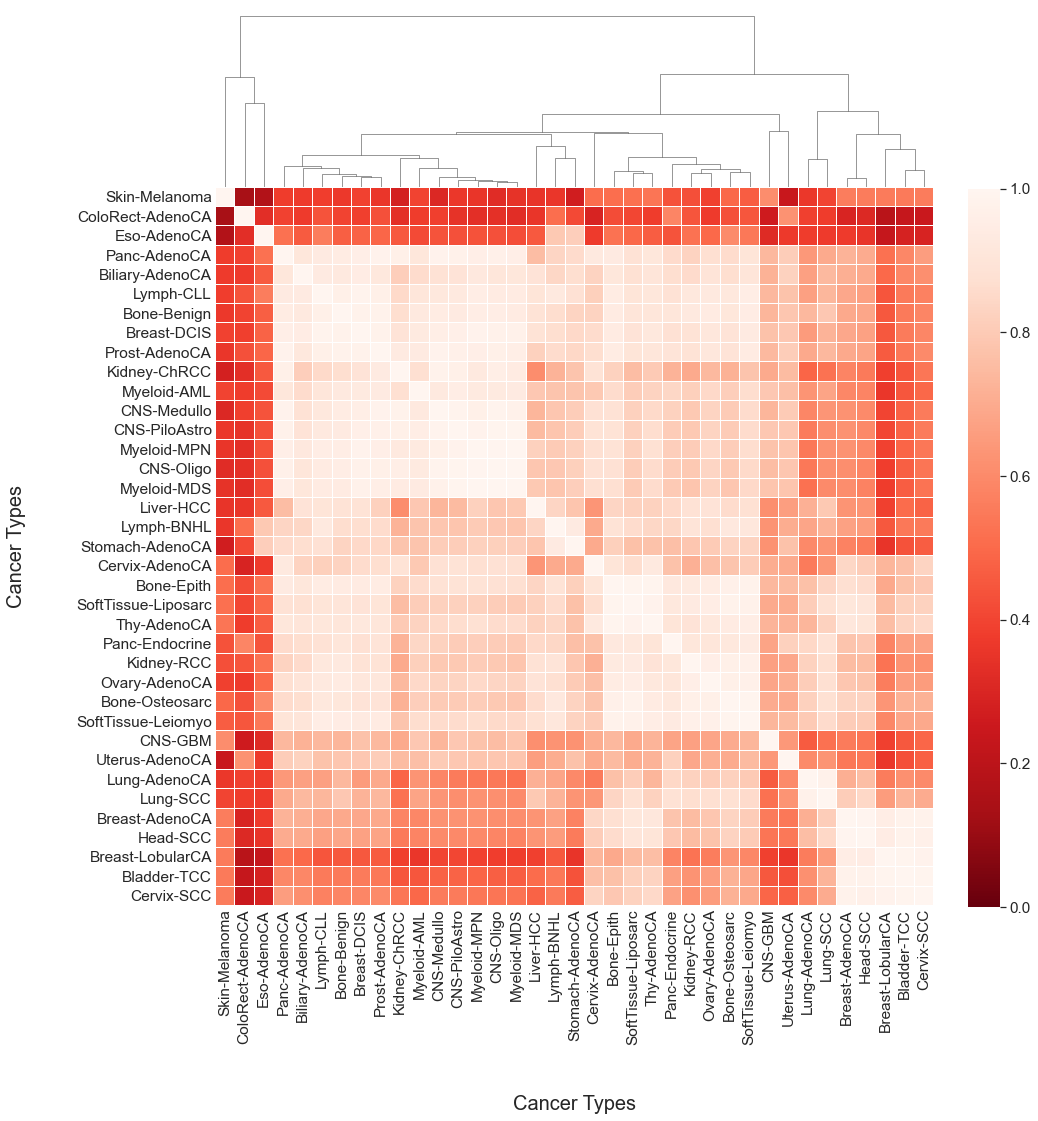

In [30]:
sns.set(font_scale=1.4)
sbs_cos = sns.clustermap(cosine_sim_sbs_96, 
                         xticklabels = cancer_type_list, 
                         yticklabels = cancer_type_list, 
                         method="average",
                         linewidths=0.004,
                         figsize=(15,15),
                         cbar_pos=(0.88, .15, .03, .665),
                         cmap = "Reds_r",
                         vmin=0)

sbs_cos.ax_row_dendrogram.set_visible(False)
sbs_cos.ax_heatmap.set_xlabel("Cancer Types", fontsize=20)
sbs_cos.ax_heatmap.set_ylabel("Cancer Types", fontsize=20)
sbs_cos.ax_heatmap.xaxis.labelpad= 50
sbs_cos.ax_heatmap.yaxis.labelpad= 50

sbs_cos.ax_heatmap.yaxis.tick_left() # x axis on top
sbs_cos.ax_heatmap.yaxis.set_label_position('left')
sbs_cos.ax_heatmap.tick_params(axis='both', which='both', length=0)

# DBS-78 type Cosine Similiarity

In [31]:
dbs_78 = pd.DataFrame(columns = range(0, 78), index = cancer_type_list)
    
for cancer in cancer_type_list:
    iter_mut_mean = mut_mean(cancer, dbs_num_data, dbs_freq_folder_path, mut_type="DBS", std_outlier=100)
    iter_mut_mean = iter_mut_mean.iloc[:, 2:].sum(axis=1)
    dbs_78.loc[cancer] = iter_mut_mean

cosine_sim_dbs_78 = cosine_similarity(dbs_78)

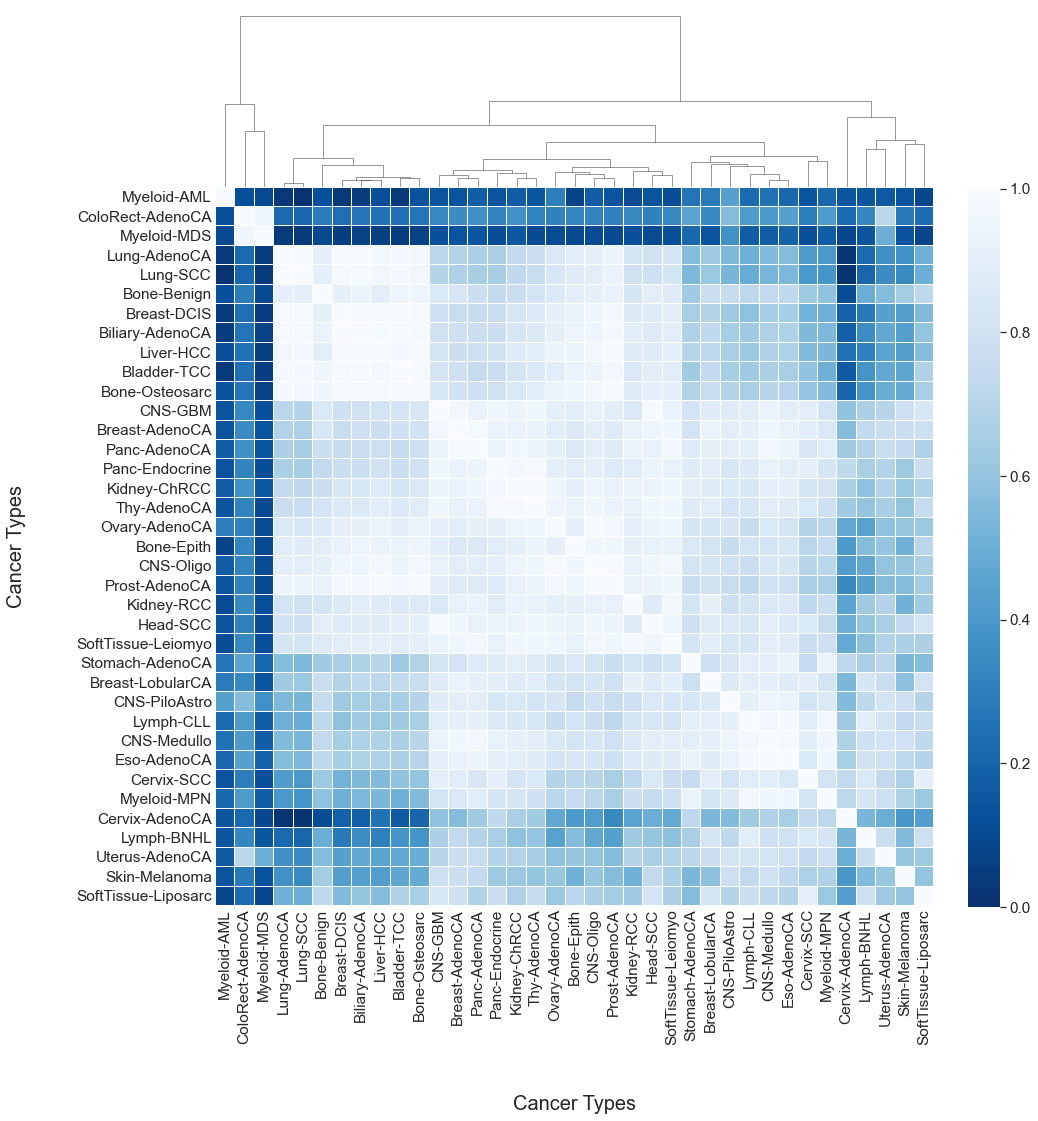

In [32]:
sns.set(font_scale=1.4)
dbs_cos = sns.clustermap(cosine_sim_dbs_78, 
                         xticklabels = cancer_type_list, 
                         yticklabels = cancer_type_list, 
                         method="average",
                         linewidths=0.004,
                         figsize=(15,15),
                         cbar_pos=(0.88, .15, .03, .665),
                         cmap="Blues_r",
                         vmin=0)

dbs_cos.ax_row_dendrogram.set_visible(False)
dbs_cos.ax_heatmap.set_xlabel("Cancer Types", fontsize=20)
dbs_cos.ax_heatmap.set_ylabel("Cancer Types", fontsize=20)
dbs_cos.ax_heatmap.xaxis.labelpad= 50
dbs_cos.ax_heatmap.yaxis.labelpad= 50

dbs_cos.ax_heatmap.yaxis.tick_left() # x axis on top
dbs_cos.ax_heatmap.yaxis.set_label_position('left')
dbs_cos.ax_heatmap.tick_params(axis='both', which='both', length=0)

# Del-12 type Cosine Similiarity

In [33]:
del_12 = pd.DataFrame(columns = range(0, 12), index = cancer_type_list)
    
for cancer in cancer_type_list:
    iter_mut_mean = mut_mean(cancer, id_num_data, id_freq_folder_path, mut_type="ID", std_outlier=100)
    iter_mut_mean = iter_mut_mean.iloc[:12, 5:].sum(axis=1)
    del_12.loc[cancer] = iter_mut_mean

cosine_sim_del_12 = cosine_similarity(del_12)

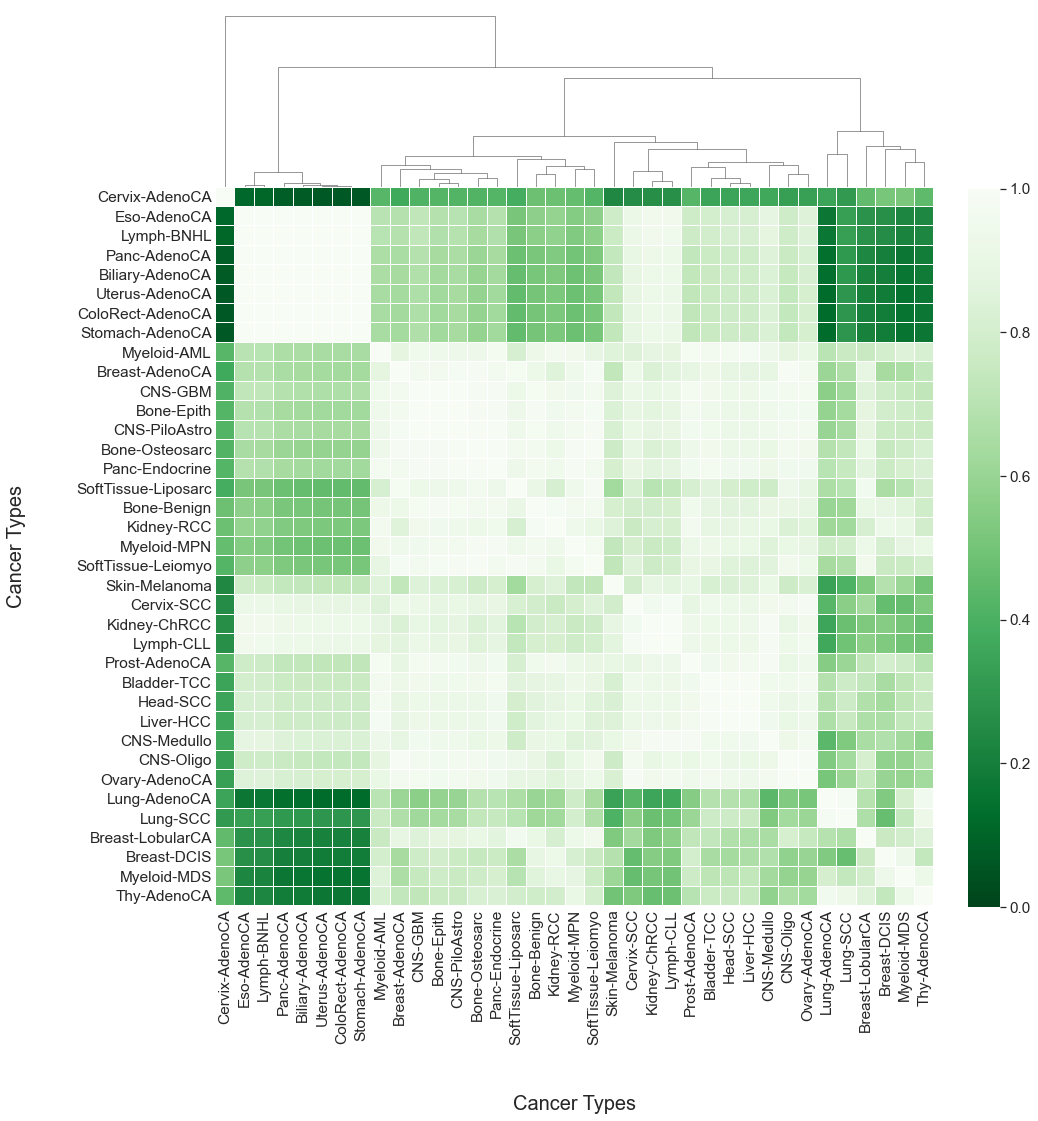

In [34]:
sns.set(font_scale=1.4)
del_cos = sns.clustermap(cosine_sim_del_12, 
                         xticklabels = cancer_type_list, 
                         yticklabels = cancer_type_list, 
                         method="average",
                         linewidths=0.004,
                         figsize=(15,15),
                         cbar_pos=(0.88, .15, .03, .665),
                         cmap="Greens_r",
                         vmin=0)

del_cos.ax_row_dendrogram.set_visible(False)
del_cos.ax_heatmap.set_xlabel("Cancer Types", fontsize=20)
del_cos.ax_heatmap.set_ylabel("Cancer Types", fontsize=20)
del_cos.ax_heatmap.xaxis.labelpad= 50
del_cos.ax_heatmap.yaxis.labelpad= 50

del_cos.ax_heatmap.yaxis.tick_left() # x axis on top
del_cos.ax_heatmap.yaxis.set_label_position('left')
del_cos.ax_heatmap.tick_params(axis='both', which='both', length=0)

# Ins-12 type Cosine Similiarity

In [35]:
ins_12 = pd.DataFrame(columns = range(12, 24), index = cancer_type_list)
    
for cancer in cancer_type_list:
    iter_mut_mean = mut_mean(cancer, id_num_data, id_freq_folder_path, mut_type="ID", std_outlier=100)
    iter_mut_mean = iter_mut_mean.iloc[12:24, 5:].sum(axis=1)
    ins_12.loc[cancer] = iter_mut_mean

cosine_sim_ins_12 = cosine_similarity(ins_12)

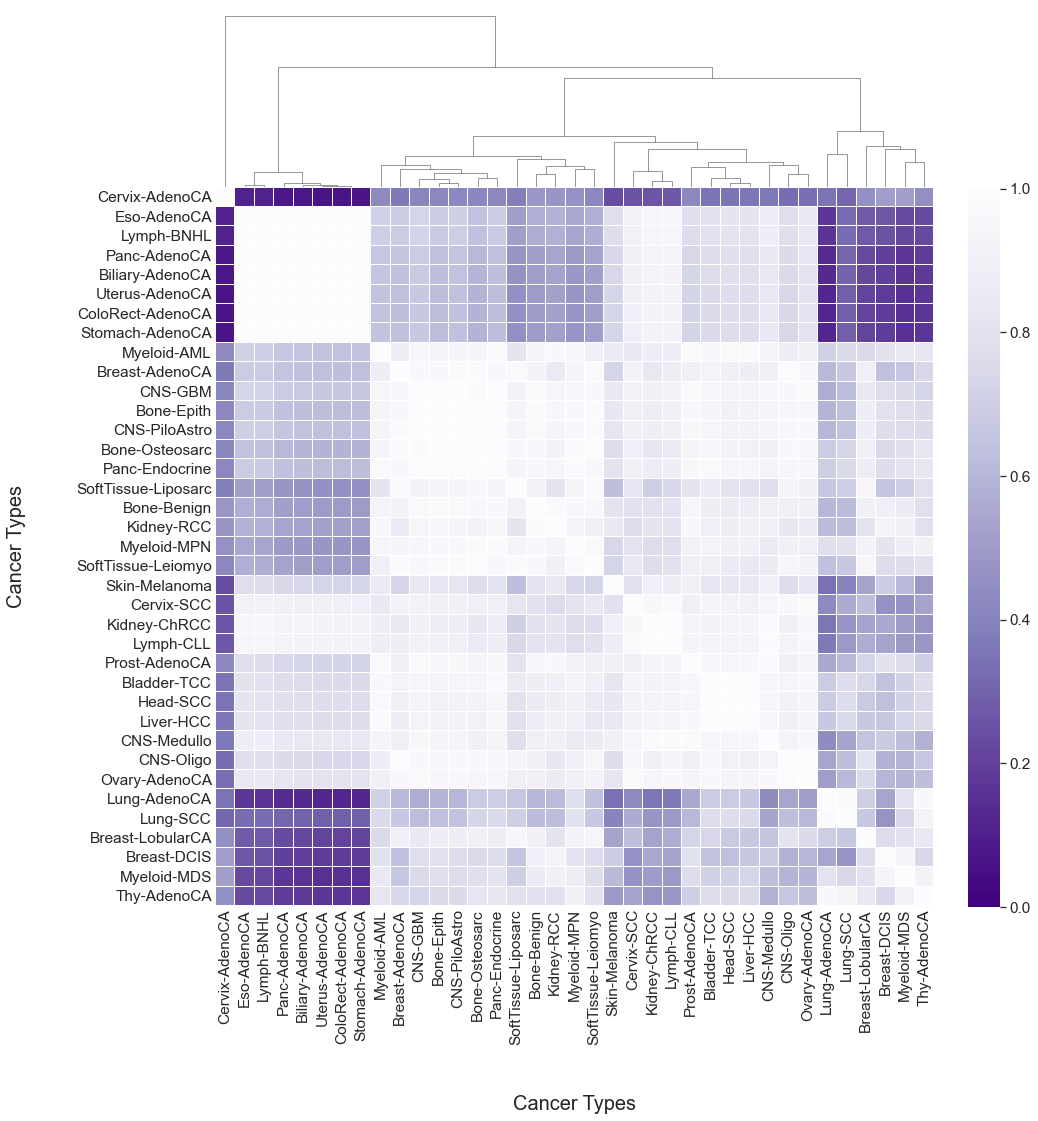

In [36]:
sns.set(font_scale=1.4)
ins_cos = sns.clustermap(cosine_sim_del_12, 
                         xticklabels = cancer_type_list, 
                         yticklabels = cancer_type_list, 
                         method="average",
                         linewidths=0.004,
                         figsize=(15,15),
                         cbar_pos=(0.88, .15, .03, .665),
                         cmap="Purples_r",
                         vmin=0)

ins_cos.ax_row_dendrogram.set_visible(False)
ins_cos.ax_heatmap.set_xlabel("Cancer Types", fontsize=20)
ins_cos.ax_heatmap.set_ylabel("Cancer Types", fontsize=20)
ins_cos.ax_heatmap.xaxis.labelpad= 50
ins_cos.ax_heatmap.yaxis.labelpad= 50

ins_cos.ax_heatmap.yaxis.tick_left() # x axis on top
ins_cos.ax_heatmap.yaxis.set_label_position('left')
ins_cos.ax_heatmap.tick_params(axis='both', which='both', length=0)